# Especialização em Inteligência Artificial – IFMG
## Trabalho da disciplina de Aprendizado de Máquina
**Autor**: Alexandre Fortes Santana

**Professor**: Professor Frederico Gadelha Guimarães - DCC – UFMG

# Dataset 1: Fórmula 1 (1950 - 2023)

Data set selecionado: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?select=results.csv

Descrição da base no Kaggle:

**About Dataset**

**Context**

*Formula 1 (a.k.a. F1 or Formula One) is the highest class of single-seater auto racing sanctioned by the Fédération Internationale de l'Automobile (FIA) and owned by the Formula One Group. The FIA Formula One World Championship has been one of the premier forms of racing around the world since its inaugural season in 1950. The word "formula" in the name refers to the set of rules to which all participants' cars must conform. A Formula One season consists of a series of races, known as Grands Prix, which take place worldwide on purpose-built circuits and on public roads.*

**Content**

*The dataset consists of all information on the Formula 1 races, drivers, constructors, qualifying, circuits, lap times, pit stops, championships from 1950 till the latest 2023 season.*

**Acknowledgements**

*The data is compiled from http://ergast.com/mrd/*

**Inspiration**

*Races are won at the track. Championships are won at the factory. - Mercedes (2019)

With the amount of data being captured, analyzed and used to design, build and drive the Formula 1 cars is astounding. It is a global sport being followed by millions of people worldwide and it is very fascinating to see drivers pushing their limit in these vehicles to become the fastest racers in the world!*

## Objetivo

No decorrer do curso "Python para Ciência de Dados", concentrei minha atenção na análise de uma base de dados pertencente ao universo da Fórmula 1. Inicialmente, meu objetivo era a construção de um modelo capaz de prever vitórias, colocações no pódio e acúmulos de pontos em corridas.

No entanto, durante o processo de desenvolvimento e teste, percebi uma forte correlação entre a posição de largada, também conhecida como grid de largada, e os resultados das corridas. Embora este seja um fator relevante para o desempenho em uma corrida, ele tornou o modelo excessivamente dependente dessa variável, prejudicando sua capacidade de fazer previsões confiáveis com base em outros parâmetros.

Compartilhei esta observação durante uma de nossas discussões em sala de aula, e foi então que meu colega Marco Antônio sugeriu uma abordagem alternativa: em vez de prever os resultados das corridas, por que não tentar prever o grid de largada? Esta proposta alinhou-se perfeitamente com meu objetivo de compreender melhor o desempenho de pilotos e equipes ao longo do tempo.

Assim, para o trabalho da disciplina de Aprendizado de Máquina, decidi manter a mesma base de dados da Fórmula 1, porém ajustando o foco do modelo para prever o grid de largada, conforme a sugestão de Marco Antônio. Com isso, espero desenvolver um modelo mais robusto e com maior capacidade de generalização, que me permitirá analisar de forma mais precisa o desempenho dos pilotos e equipes.

## Preparo dos dados

### Organização dos atributos

In [1]:
import pandas as pd
import numpy as np

# Remove display limit
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', None)

df_race_results = pd.read_csv('F1/results.csv').add_prefix('result_')
df_races = pd.read_csv('F1/races.csv').add_prefix('race_')
df_constructors = pd.read_csv('F1/constructors.csv').add_prefix('constructor_')
df_drivers = pd.read_csv('F1/drivers.csv').add_prefix('driver_')

# Merge
merged_df = pd.merge(df_race_results, df_races, left_on='result_raceId', right_on='race_raceId', how='left')
merged_df = pd.merge(merged_df, df_drivers, left_on='result_driverId', right_on='driver_driverId', how='left')
merged_df = pd.merge(merged_df, df_constructors, left_on='result_constructorId', right_on='constructor_constructorId', how='left')

# Ajustando alguns nomes de colunas para melhor legibilidade
merged_df.rename(columns={'result_grid': 'result_starting_grid', 'result_positionOrder' : 'result_final_position', 'driver_driverRef' : 'driver_name'}, inplace=True)
# Remover colunas não utilizadas
merged_df.drop(['result_laps', 'driver_forename', 'driver_surname', 'constructor_constructorId','constructor_constructorRef','constructor_url','driver_code','driver_dob','driver_driverId','driver_number','race_circuitId','race_date','race_fp1_date','race_fp1_time','race_fp2_date','race_fp2_time','race_fp3_date','race_fp3_time','race_quali_date','race_quali_time','race_raceId','race_round','race_sprint_date','race_sprint_time','race_time','result_constructorId','result_driverId','result_fastestLap','result_fastestLapSpeed','result_fastestLapTime','result_milliseconds','result_number','result_position','result_positionText','result_raceId','result_rank','result_statusId','result_time'], axis=1, inplace=True)

### Avaliar a poporção de dados faltantes

In [2]:
nan_proportion = merged_df.isna().mean()
nan_proportion

result_resultId            0.0
result_starting_grid       0.0
result_final_position      0.0
result_points              0.0
race_year                  0.0
race_name                  0.0
race_url                   0.0
driver_name                0.0
driver_nationality         0.0
driver_url                 0.0
constructor_name           0.0
constructor_nationality    0.0
dtype: float64

### Avaliar tipo dos dados

In [3]:
print(merged_df.dtypes)

result_resultId              int64
result_starting_grid         int64
result_final_position        int64
result_points              float64
race_year                    int64
race_name                   object
race_url                    object
driver_name                 object
driver_nationality          object
driver_url                  object
constructor_name            object
constructor_nationality     object
dtype: object


# Análise Exploratória

## Performance de equipes por ano

Vamos analisar como foi a jornada das equipes com maior número de poles da história da Fórmula 1 até este momento.

### Prepara dados das equipes

In [4]:
# Calcule o total de corridas por ano
total_corridas_por_ano = merged_df.groupby('race_year')['race_name'].nunique().rename('total_corridas')

# Agrupe por ano, some as pole positions
poles_por_construtor = merged_df.groupby(['race_year', 'constructor_name']).agg({'result_starting_grid': lambda x: (x==1).sum()}) 

# Renomear para clareza
poles_por_construtor.rename(columns={'result_starting_grid': 'poles'}, inplace=True)

# Resetar índice para unir com total_corridas_por_ano
poles_por_construtor = poles_por_construtor.reset_index()

# Junte com total_corridas_por_ano para incluir total de corridas em cada ano
poles_por_construtor = poles_por_construtor.merge(total_corridas_por_ano, on='race_year')

# Calcule a média de poles
poles_por_construtor['media_poles'] = poles_por_construtor['poles'] / poles_por_construtor['total_corridas']

# Para cada ano, obtenha os top 3 construtores com mais poles
poles_por_construtor = poles_por_construtor.groupby('race_year').apply(lambda x: x.nlargest(3, 'poles')).reset_index(drop=True)

# Remova construtores sem poles
poles_por_construtor = poles_por_construtor[poles_por_construtor['poles'] > 0]
poles_por_construtor


,race_year,constructor_name,poles,total_corridas,media_poles
0,1950,Alfa Romeo,6,7,0.857143
1,1950,Kurtis Kraft,1,7,0.142857
3,1951,Alfa Romeo,5,8,0.625000
4,1951,Ferrari,3,8,0.375000
5,1951,Kurtis Kraft,1,8,0.125000
...,...,...,...,...,...
214,2021,Mercedes,9,22,0.409091
215,2021,Ferrari,2,22,0.090909
216,2022,Ferrari,12,22,0.545455
217,2022,Red Bull,8,22,0.363636


### Análise de poles

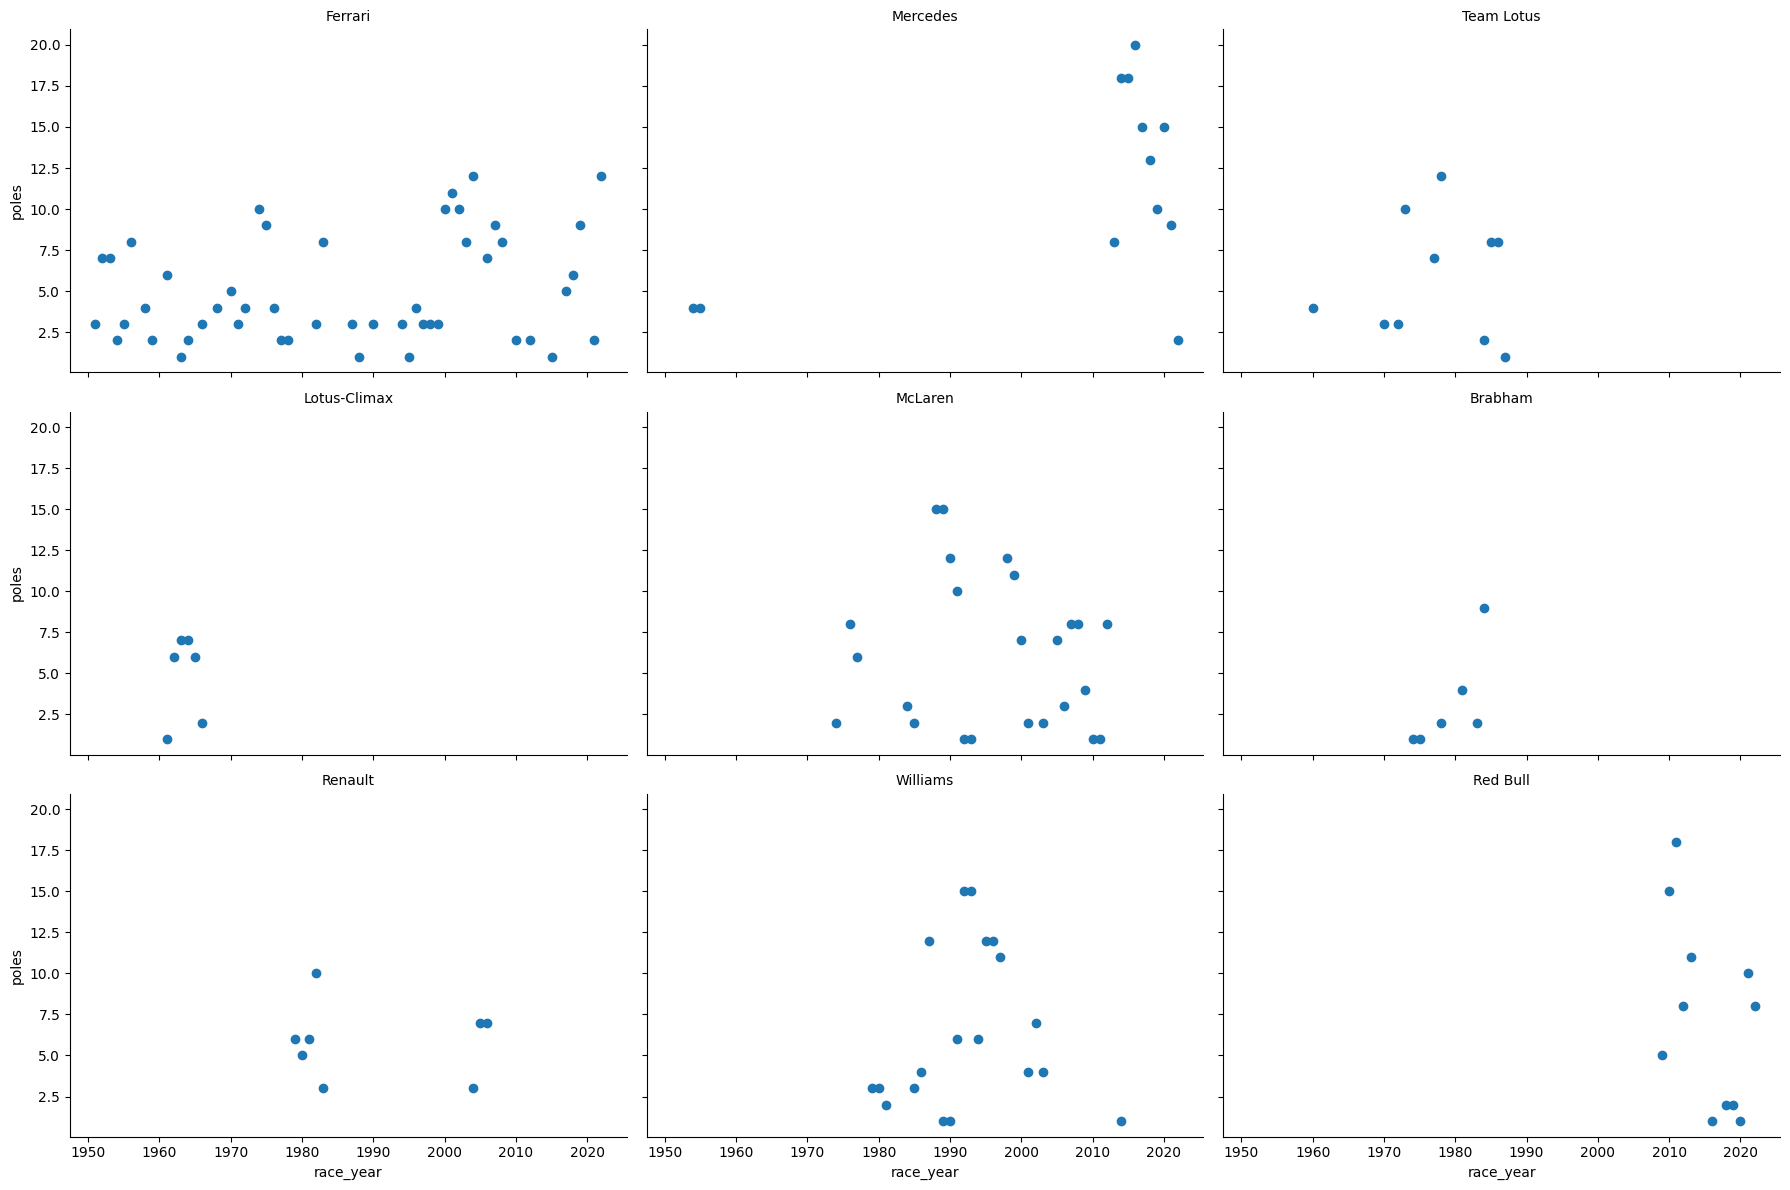

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# 9 principais construtores
principais_construtores_para_plotar = poles_por_construtor.groupby('constructor_name')['poles'].sum().nlargest(9).index

# Extrai dados desses construtores
poles_por_construtor_para_plotar = poles_por_construtor[poles_por_construtor['constructor_name'].isin(principais_construtores_para_plotar)]

# FacetGrid 
g = sns.FacetGrid(poles_por_construtor_para_plotar, col='constructor_name', col_wrap=3, height=4, aspect=1.5)

# Um construtor por bloco
g = g.map(plt.scatter, 'race_year', 'poles')

# Adicione título
g = g.set_titles("{col_name}")

## Performance de pilotos por ano

Vamos analisar como foi a jornada dos pilotos com maior número de poles da história da Fórmula 1 até este momento.

### Prepara dados dos pilotos

In [6]:
# Calcula o total de corridas por ano
total_corridas_por_ano = merged_df.groupby('race_year')['race_name'].nunique().rename('total_corridas')

# Agrupa por ano, soma as pole positions
poles_por_piloto = merged_df[merged_df['result_starting_grid'] == 1].groupby(['race_year', 'driver_name']).size().rename('poles')

# Reconfigura o índice para mesclar com total_corridas_por_ano
poles_por_piloto = poles_por_piloto.reset_index()

# Mescla com total_corridas_por_ano para incluir total de corridas em cada ano
poles_por_piloto = poles_por_piloto.merge(total_corridas_por_ano, on='race_year')

# Calcula a média de poles
poles_por_piloto['media_poles'] = poles_por_piloto['poles'] / poles_por_piloto['total_corridas']

# Para cada ano, obtém os 3 pilotos com mais poles
poles_por_piloto = poles_por_piloto.groupby('race_year').apply(lambda x: x.nlargest(3, 'poles')).reset_index(drop=True)

# Remove pilotos sem poles
poles_por_piloto = poles_por_piloto[poles_por_piloto['poles'] > 0]
poles_por_piloto

,race_year,driver_name,poles,total_corridas,media_poles
0,1950,fangio,4,7,0.571429
1,1950,farina,2,7,0.285714
2,1950,faulkner,1,7,0.142857
3,1951,fangio,4,8,0.500000
4,1951,ascari,2,8,0.250000
...,...,...,...,...,...
213,2021,hamilton,5,22,0.227273
214,2021,bottas,4,22,0.181818
215,2022,leclerc,9,22,0.409091
216,2022,max_verstappen,7,22,0.318182


### Análise de vitórias

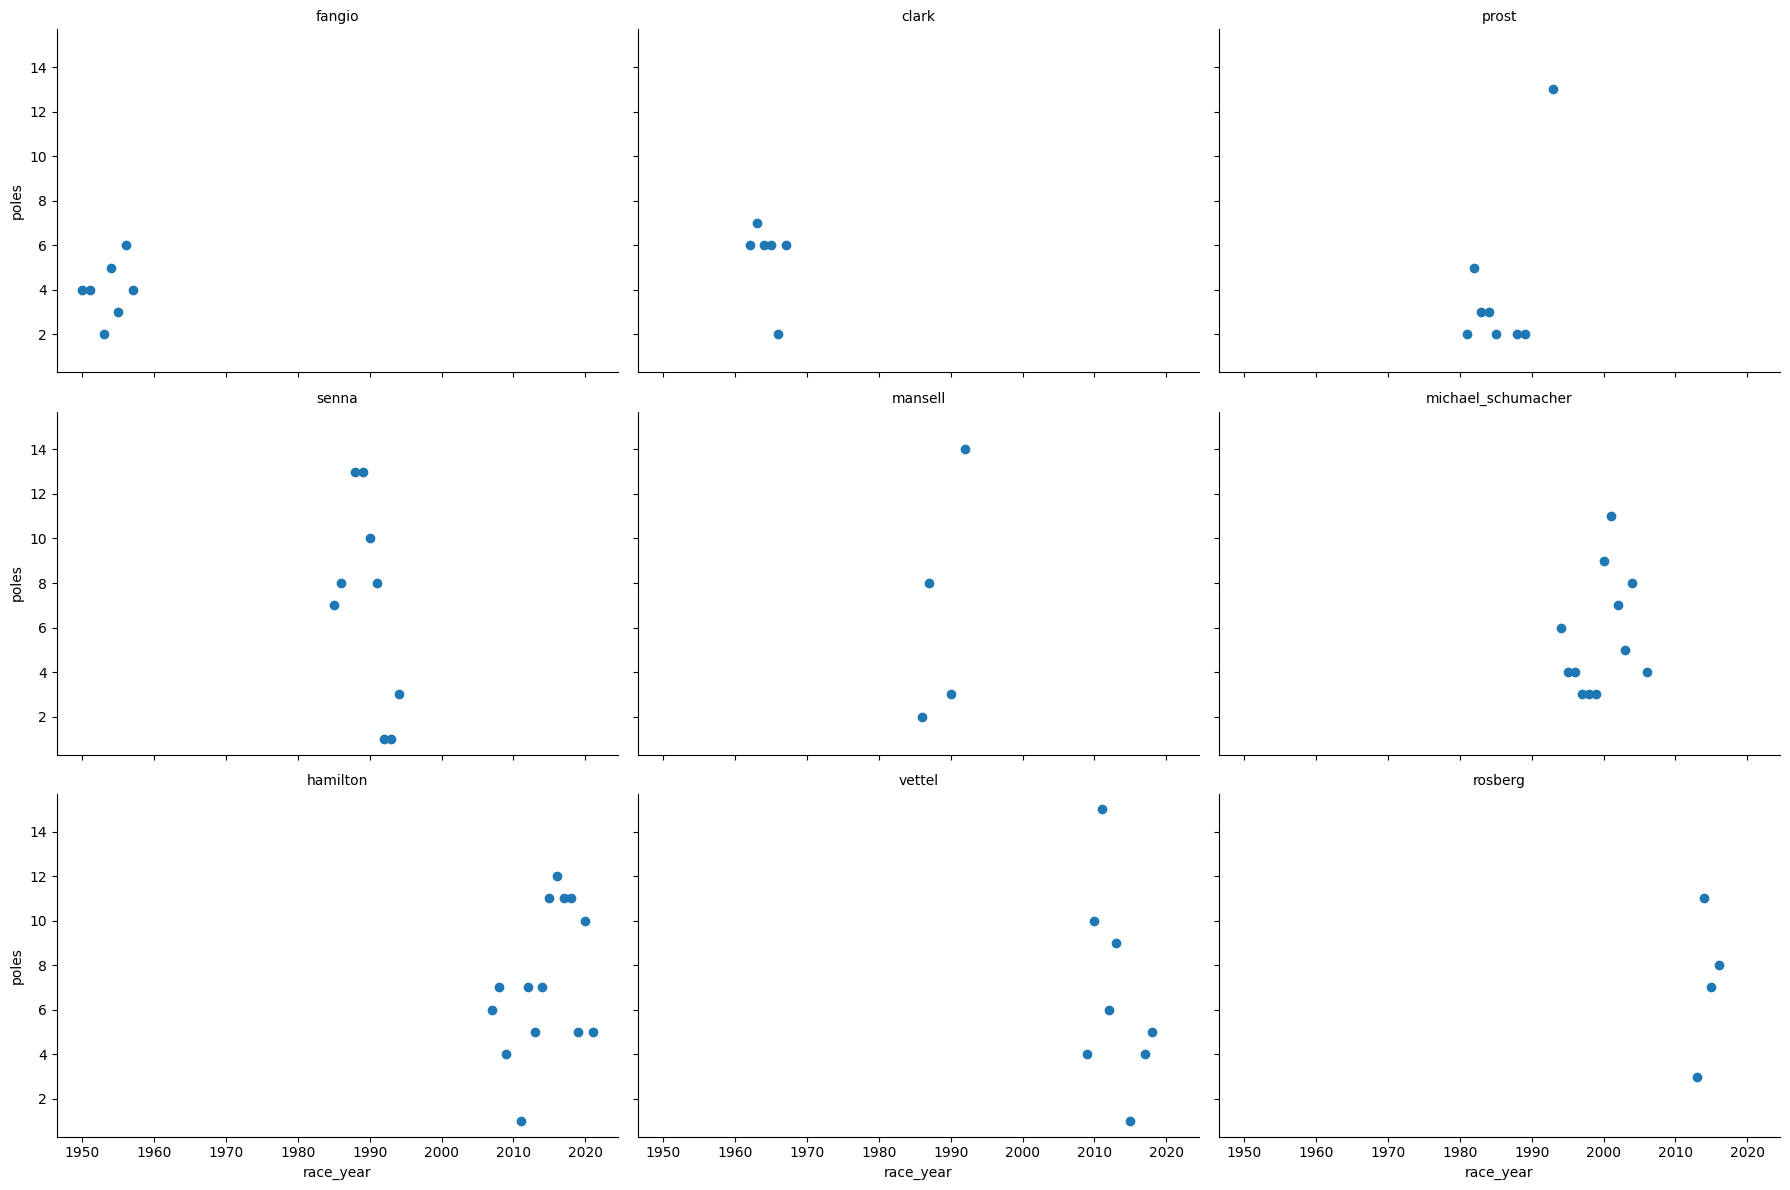

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 9 pilotos principais
top_pilotos_para_plotar = poles_por_piloto.groupby('driver_name')['poles'].sum().nlargest(9).index

# Extrai dados desses pilotos
poles_por_piloto_para_plotar = poles_por_piloto[poles_por_piloto['driver_name'].isin(top_pilotos_para_plotar)]

# FacetGrid
g = sns.FacetGrid(poles_por_piloto_para_plotar, col='driver_name', col_wrap=3, height=4, aspect=1.5)

# Um piloto por bloco
g = g.map(plt.scatter, 'race_year', 'poles')

# Adiciona título
g = g.set_titles("{col_name}")

## Aplicando métdos de aprendizado para Classificação

A análise de dados da Fórmula 1 é bastante complexa, afinal, envolve variáveis de diversos tipos como saúde do piloto, mecânica dos carros, condição das pistas, clima, etc. Entretanto, para fins acadêmicos, estamos usando um modelo de classificação simples para prever se um piloto começará no podium.

Os atributos de treinamento serão:

- `race_name`
- `driver_name`
- `constructor_name`
- `race_year`

Queremos prever a variável `result_starting_grid`.

### Preparo dos dados e verificando balanço de classes

In [39]:
# Copiando o dataframe original para uso no treinamento
merged_df_to_go = merged_df[['race_name', 'driver_name', 'constructor_name', 'race_year', 'result_starting_grid']].copy()

# Convertendo `result_starting_grid` para 2 possíveis classes: true (para pole) e false (para o restante). 
merged_df_to_go['result_starting_grid'] = merged_df_to_go['result_starting_grid'].apply(lambda x: True if x == 1 else False)

In [40]:
merged_df_to_go.dtypes

race_name               object
driver_name             object
constructor_name        object
race_year                int64
result_starting_grid      bool
dtype: object

In [24]:
# Verificando o balanceamento de classes
counts = merged_df_to_go['result_starting_grid'].value_counts(normalize=True)
print(counts)

result_starting_grid
False    0.957817
True     0.042183
Name: proportion, dtype: float64


## Separando os dados em conjuntos de treinamento utilizando k-fold

K-NN:
  accuracy: 0.9484133126934984
  precision: 0.20967338217338213
  recall: 0.11714209704980698
  roc_auc: 0.5511066066574604
  specificity: 0.9850711162651133
  f1_score: 0.14401606053874802

Naive Bayes:
  accuracy: 0.9578173374613004
  precision: 0.0
  recall: 0.0
  roc_auc: 0.5
  specificity: 1.0
  f1_score: 0.0

Decision Tree:
  accuracy: 0.9347136222910215
  precision: 0.19498915219001633
  recall: 0.19324993082639308
  roc_auc: 0.5803224762726525
  specificity: 0.9673950217189121
  f1_score: 0.1910771954836788



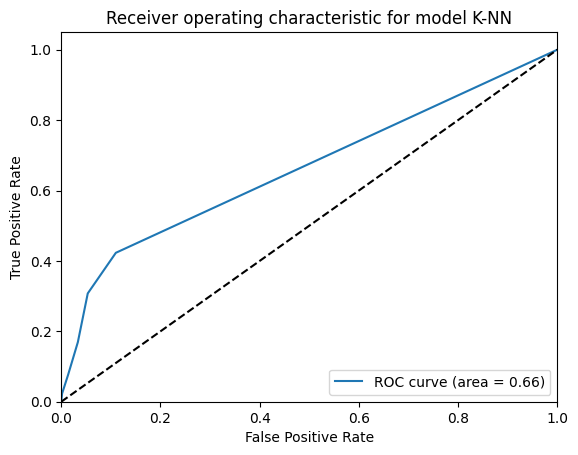

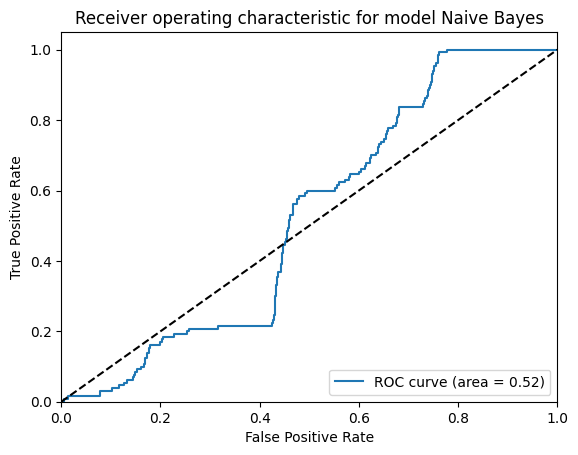

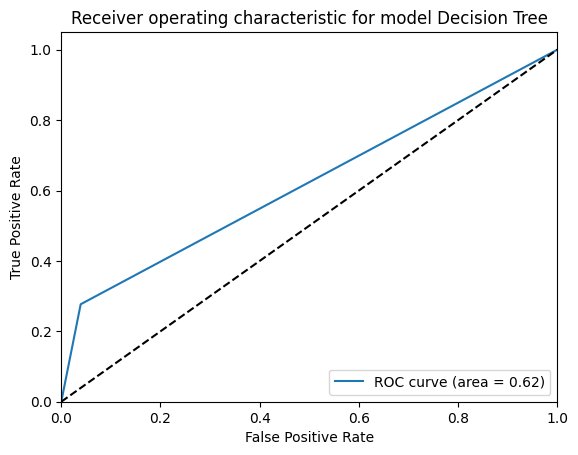

In [49]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Clonando o dataframe
merged_df_test = merged_df_to_go.copy()

# Definindo a quantidade de folds
n_folds = 10

# Criando o objeto KFold
kf = KFold(n_splits=n_folds)


# Dividindo o dataframe em recursos e rótulos
X = merged_df_to_go.drop('result_starting_grid', axis=1)
y = merged_df_to_go['result_starting_grid']

# Encoder para converter variáveis categóricas em numéricas
le = LabelEncoder()
# Codificando as variáveis categóricas
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col])

# Definindo os modelos
models = {
    "K-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier()
}

# Dicionário para armazenar os scores de cada modelo
model_scores = {}

# Aplicando o k-fold no dataframe
for model_name, model in models.items():
    scores = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "roc_auc": [],
        "specificity": [],
        "f1_score": []
    }
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Treinando o modelo com os dados de treinamento
        model.fit(X_train, y_train)

        # Fazendo previsões com os dados de teste
        predictions = model.predict(X_test)

        # Calculando as métricas da iteração
        scores["accuracy"].append(accuracy_score(y_test, predictions))
        scores["precision"].append(precision_score(y_test, predictions, zero_division=0))
        scores["recall"].append(recall_score(y_test, predictions))
        scores["roc_auc"].append(roc_auc_score(y_test, predictions))

        # Calculando a especificidade
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        specificity = tn / (tn+fp)
        scores["specificity"].append(specificity)
        
        # Calculando o F1-Score
        scores["f1_score"].append(f1_score(y_test, predictions, zero_division=0))

    # Armazenando os scores do modelo
    model_scores[model_name] = scores

# Imprimindo os scores médios para cada modelo

# Imprimindo os scores médios para cada modelo
for model_name, scores in model_scores.items():
    print(f"{model_name}:")
    for score_name, score_values in scores.items():
        print(f"  {score_name}: {sum(score_values) / len(score_values)}")
    print()

# Plotando a curva ROC para cada modelo
for model_name, model in models.items():
    # Calculando as probabilidades de cada classe
    y_scores = model.predict_proba(X_test)

    # Calculando a taxa de verdadeiros positivos e a taxa de falsos positivos
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])

    # Calculando a AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plotando a curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for model ' + model_name)
    plt.legend(loc="lower right")
    plt.show()


### Interpretando os resultados

Nenhuma métrica ficou boa.

## Testando One Hot Encoder

Ao contrário do LabelEncoder, que codifica as categorias como inteiros, o OneHotEncoder codifica as categorias como vetores binários. Isso é útil pois estamos lidando com variáveis categóricas nominais, onde não há nenhuma ordem ou hierarquia nas categorias.

K-NN:
  accuracy: 0.953018575851393
  precision: 0.32603649770281407
  recall: 0.16363759714930343
  roc_auc: 0.5756407053647161
  specificity: 0.9876438135801289
  f1_score: 0.20496546703891486

Naive Bayes:
  accuracy: 0.5644736842105263
  precision: 0.07286822936586348
  recall: 0.7885406935828422
  roc_auc: 0.6714396562259745
  specificity: 0.5543386188691068
  f1_score: 0.13309108184467877

Decision Tree:
  accuracy: 0.9405572755417957
  precision: 0.2529952140639609
  recall: 0.21681289730523728
  roc_auc: 0.5945913688155737
  specificity: 0.97236984032591
  f1_score: 0.22315265280736715



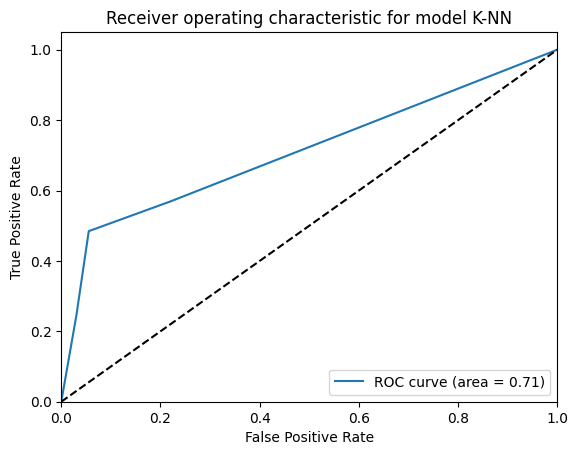

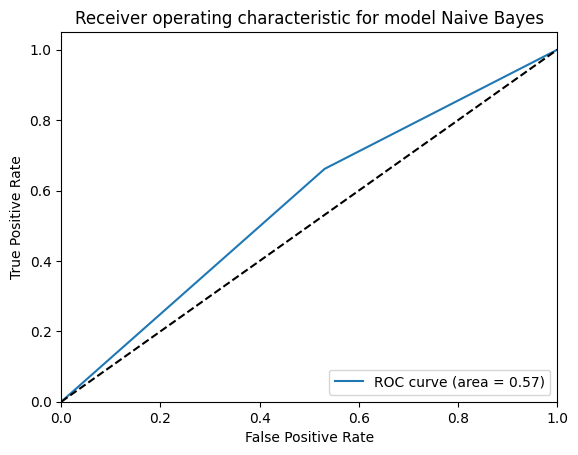

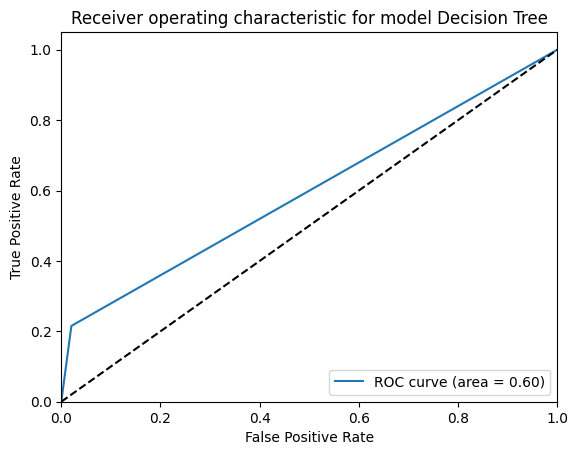

In [48]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Copiando o dataframe original para uso no treinamento
merged_df_to_go = merged_df[['race_name', 'driver_name', 'constructor_name', 'race_year', 'result_starting_grid']].copy()

# Convertendo `result_starting_grid` para 2 possíveis classes: true (para pole) e false (para o restante). 
merged_df_to_go['result_starting_grid'] = merged_df_to_go['result_starting_grid'].apply(lambda x: 1 if x == 1 else 0)

merged_df_to_go.dtypes

# Clonando o dataframe
merged_df_test = merged_df_to_go.copy()

# Definindo a quantidade de folds
n_folds = 10

# Criando o objeto KFold
kf = KFold(n_splits=n_folds)


# Dividindo o dataframe em recursos e rótulos
X = merged_df_to_go.drop('result_starting_grid', axis=1)
y = merged_df_to_go['result_starting_grid']

# Aplicando o OneHotEncoder para as colunas categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Definindo os modelos
models = {
    "K-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier()
}

# Dicionário para armazenar os scores de cada modelo
model_scores = {}

# Aplicando o k-fold no dataframe
for model_name, model in models.items():
    scores = {
        "accuracy": [],
        "precision": [],
        "recall": [],
        "roc_auc": [],
        "specificity": [],
        "f1_score": []
    }
    
    for train_index, test_index in kf.split(X_encoded):
        X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = np.ascontiguousarray(X_train.values)

        # Estava enfrentando o erro 'Flags' object has no attribute 'c_contiguous' 
        # Pelo que pesquisei esse erro geralmente está relacionado com operações em estruturas de dados numpy que exigem continuidade de memória. 
        # numpy.ascontiguousarray() retorna uma matriz contígua na memória 
        X_test = np.ascontiguousarray(X_test.values)
        y_train = np.ascontiguousarray(y_train.values)
        y_test = np.ascontiguousarray(y_test.values)

        # Treinando o modelo com os dados de treinamento
        model.fit(X_train, y_train)

        # Fazendo previsões com os dados de teste
        predictions = model.predict(X_test)

        # Calculando as métricas da iteração
        scores["accuracy"].append(accuracy_score(y_test, predictions))
        scores["precision"].append(precision_score(y_test, predictions, zero_division=0))
        scores["recall"].append(recall_score(y_test, predictions))
        scores["roc_auc"].append(roc_auc_score(y_test, predictions))

        # Calculando a especificidade
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        specificity = tn / (tn+fp)
        scores["specificity"].append(specificity)
        
        # Calculando o F1-Score
        scores["f1_score"].append(f1_score(y_test, predictions, zero_division=0))

    # Armazenando os scores do modelo
    model_scores[model_name] = scores

# Imprimindo os scores médios para cada modelo
for model_name, scores in model_scores.items():
    print(f"{model_name}:")
    for score_name, score_values in scores.items():
        print(f"  {score_name}: {sum(score_values) / len(score_values)}")
    print()

# Plotando a curva ROC para cada modelo
for model_name, model in models.items():
    # Calculando as probabilidades de cada classe
    y_scores = model.predict_proba(X_test)

    # Calculando a taxa de verdadeiros positivos e a taxa de falsos positivos
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])

    # Calculando a AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plotando a curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for model ' + model_name)
    plt.legend(loc="lower right")
    plt.show()


### Interpretando resultados com One Hot Encoder

#### Resultados com ONe Hot Encoder

K-NN:  
>  accuracy: 0.953018575851393  
  precision: 0.32603649770281407  
  recall: 0.16363759714930343  
  roc_auc: 0.5756407053647161  
  specificity: 0.9876438135801289  
  f1_score: 0.20496546703891486  

Naive Bayes:  
>  accuracy: 0.5644736842105263  
  precision: 0.07286822936586348  
  recall: 0.7885406935828422  
  roc_auc: 0.6714396562259745  
  specificity: 0.5543386188691068  
  f1_score: 0.13309108184467877  

Decision Tree:  
>  accuracy: 0.9405572755417957  
  precision: 0.2529952140639609  
  recall: 0.21681289730523728  
  roc_auc: 0.5945913688155737  
  specificity: 0.97236984032591  
  f1_score: 0.22315265280736715  

K-NN:
Este modelo apresenta alta acurácia (0.95) e alta especificidade (0.98), indicando que ele é muito bom em prever corretamente as previsões negativas e em fazer previsões corretas em geral. No entanto, sua precisão (0.32) e recall (0.16) são baixos, indicando que o modelo não é tão bom em prever corretamente as previsões positivas e tem dificuldade em identificar positivos. A área sob a curva ROC (0.57) é moderadamente boa, sugerindo que o modelo tem um desempenho razoável. O F1_score (20.5%) indica que o modelo tem um desempenho ruim tanto em Precisão quanto em Recall.

Naive Bayes:
Este modelo tem uma acurácia mais baixa (0.56) e precisão muito baixa (0.07), mas tem um alto recall (0.78), indicando que é muito bom em identificar positivos, mas muitas das previsões positivas estão incorretas. A especificidade é moderada (0.55) e a área sob a curva ROC é moderada a boa (0.67), indicando que o modelo tem um desempenho razoável a bom. O F1_score (13.3%) é baixo.

Decision Tree:
Este modelo apresenta alta acurácia (0.94) e alta especificidade (0.97), semelhante ao K-NN. A precisão (0.25) e recall (0.23) são baixos, mas um pouco melhores do que os do K-NN, e a Aárea sob a curva ROCUC (0.60) é moderadamente boa, sugerindo que o modelo tem um desempenho geral ligeiramente melhor do que o K-NN. O F1_score (22.3%) é baixo.

#### Média harmônica da previsão e revocação (F1-Score)

#### Conclusão
Até agora, nenhum modelo ficou com desempenho aceitável

## Testando foco em 2 anos específicos, 2021 e 2022

>  .  
>  .  
>  .  
>  .  
>  .  
>  .  
>  .  
>  .  
>  .  
>  .  
>  .  
>  .  
>  .  
>  .  
>  .  
>  .  

### Testando Modelos de Aprendizado

Verificando balanceamento da classe "podium_finish":

In [42]:
# Check the balance of the 'podium_finish' column
counts = merged_df_encoded['podium_finish'].value_counts(normalize=True)
print(counts)

podium_finish
3    0.579683
2    0.294195
1    0.084249
0    0.041873
Name: proportion, dtype: float64


Equilibrando as classes para o teste e removendo dados antigos

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

Não utilizaremos os dados de resultado a seguir no treinamento:

In [44]:
merged_df_encoded.drop(['result_final_position', 'result_points', 'win'], axis=1, inplace=True)

In [49]:
X = merged_df_encoded.drop('podium_finish', axis=1)
y = merged_df_encoded['podium_finish']

In [50]:
clfs = [DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        KNeighborsClassifier()]

from sklearn.model_selection import cross_val_score

classifiers = []
scores = []

#f1_micro para multiclasse
for clf in clfs:
    cv_scores = cross_val_score(clf,X,y, cv=10, scoring='f1_micro', n_jobs=-1)
    for s in cv_scores:
        classifiers.append(str(clf))
        scores.append(float(s))

results = pd.DataFrame({'classifier':classifiers,'F-score':scores})
results

,classifier,F-score
0,DecisionTreeClassifier(),0.386997
1,DecisionTreeClassifier(),0.298762
2,DecisionTreeClassifier(),0.536378
3,DecisionTreeClassifier(),0.562307
4,DecisionTreeClassifier(),0.368421
5,DecisionTreeClassifier(),0.283282
6,DecisionTreeClassifier(),0.245356
7,DecisionTreeClassifier(),0.371517
8,DecisionTreeClassifier(),0.288313
9,DecisionTreeClassifier(),0.305341


<Axes: xlabel='classifier', ylabel='F-score'>

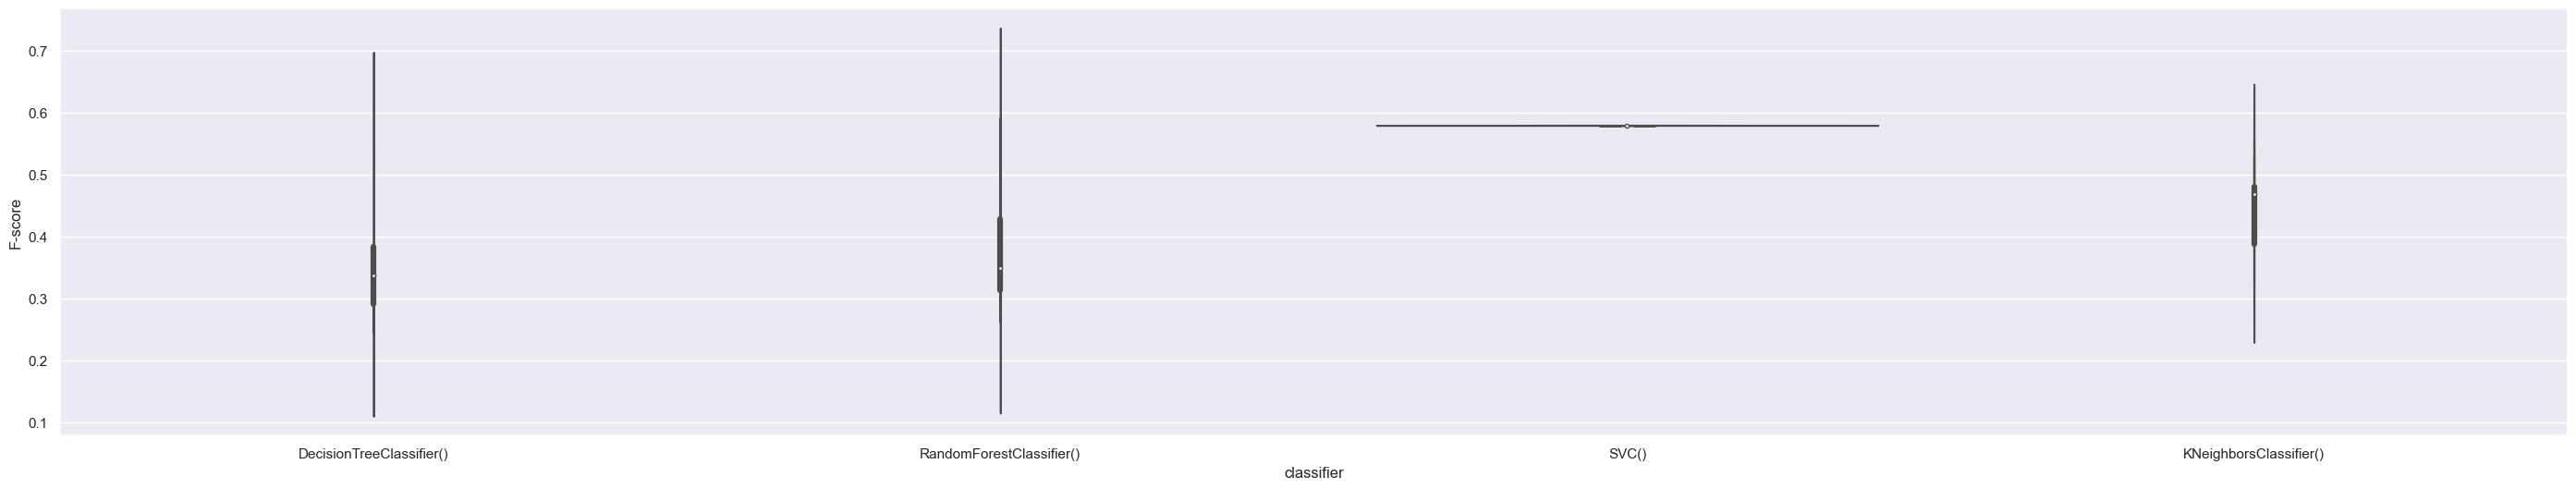

In [51]:
sns.set(rc={'figure.figsize':(35,6)})
sns.violinplot(data=results,x='classifier',y='F-score')

### Identificando melhores hyperparâmetros para DecisionTreeClassifier

In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion':['gini','entropy','log_loss'],
              'max_depth':[2,3,4,5,6,7,8,9,10],
              }

grid = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=10,scoring='f1_micro', n_jobs=-1)
grid.fit(X,y)
grid.best_params_

{'criterion': 'entropy', 'max_depth': 4}

### Identificando melhores hyperparâmetros para RandomForestClassifier

In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion':['gini','entropy'],
              'max_depth':[2,3,4,5,6,7,8,9,10],
              }

grid = GridSearchCV(RandomForestClassifier(),param_grid,cv=10,scoring='f1_micro', n_jobs=-1)
grid.fit(X,y)
grid.best_params_

{'criterion': 'gini', 'max_depth': 2}

### Identificando melhores hyperparâmetros para KNeighborsClassifier

In [54]:
# "f1_micro"
param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

grid = GridSearchCV(KNeighborsClassifier(),param_grid,cv=10,scoring='f1_micro', n_jobs=-1)
grid.fit(X,y)
grid.best_params_

{'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}

### Retreinando o modelo com os hyperparâmetros

In [55]:
#comparando modelos
clfs = [DecisionTreeClassifier(criterion='entropy', max_depth=4),
        RandomForestClassifier(criterion='gini', max_depth=2),
        KNeighborsClassifier(n_neighbors=11, p=2, weights='uniform')]
classifiers = []
scores = []
for clf in clfs:
    cv_scores = cross_val_score(clf,X,y, cv=10, scoring='f1_micro', n_jobs=-1)
    for s in cv_scores:
        classifiers.append(str(clf))
        scores.append(float(s))

results = pd.DataFrame({'classifier':classifiers,'F-score':scores})
results

,classifier,F-score
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.616486
1,"DecisionTreeClassifier(criterion='entropy', ma...",0.579334
2,"DecisionTreeClassifier(criterion='entropy', ma...",0.582043
3,"DecisionTreeClassifier(criterion='entropy', ma...",0.600619
4,"DecisionTreeClassifier(criterion='entropy', ma...",0.570820
5,"DecisionTreeClassifier(criterion='entropy', ma...",0.579721
6,"DecisionTreeClassifier(criterion='entropy', ma...",0.563080
7,"DecisionTreeClassifier(criterion='entropy', ma...",0.592492
8,"DecisionTreeClassifier(criterion='entropy', ma...",0.682663
9,"DecisionTreeClassifier(criterion='entropy', ma...",0.591718


<Axes: xlabel='classifier', ylabel='F-score'>

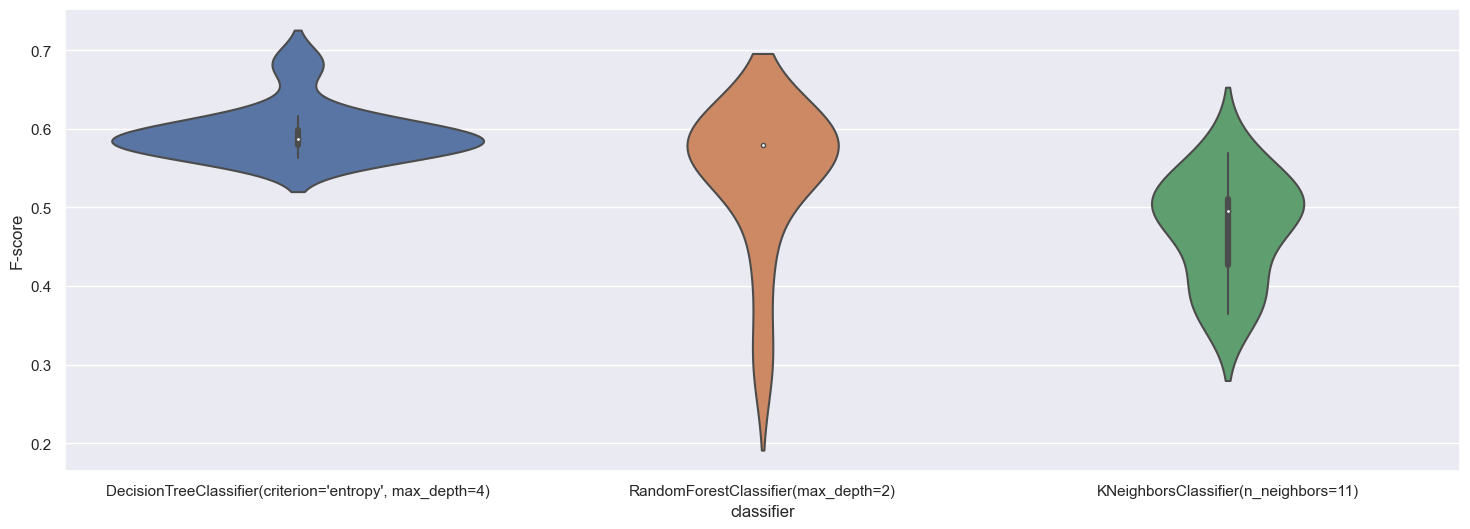

In [56]:
sns.set(rc={'figure.figsize':(18,6)})
sns.violinplot(data=results,x='classifier',y='F-score')

# Treinando modelo e fazendo previsões

## Usando o modelo DecisionTreeClassifier

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Separando o conjunto de dados em features (X) e target (y)
X = merged_df_encoded.drop('podium_finish', axis=1)
y = merged_df_encoded['podium_finish']

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Finalmente, DecisionTreeClassifier

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Definindo os hiperparâmetros a serem testados
param_grid = {'max_depth': [None, 5, 10, 15, 20, 25, 30]}

# Instanciando o modelo
dt = DecisionTreeClassifier(random_state=42)

# Instanciando o GridSearchCV
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')

# Fit no dados
grid_search.fit(X_train, y_train)

# Verificando os melhores parâmetros
print("Melhores parâmetros: ", grid_search.best_params_)
print("Melhor score: ", grid_search.best_score_)

Melhores parâmetros:  {'max_depth': 5}
Melhor score:  0.6147724957677132


In [63]:
# Criando a árvore de decisão
clf = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Treinando o modelo
clf.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Verificando a acurácia
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.42      0.42       325
           1       0.38      0.14      0.20       651
           2       0.53      0.21      0.30      2278
           3       0.65      0.90      0.75      4498

    accuracy                           0.62      7752
   macro avg       0.50      0.42      0.42      7752
weighted avg       0.58      0.62      0.56      7752



### Função de teste

In [66]:
import pandas as pd
def predict_finish_in_points(starting_grid, race_year, constructor_name, driver_name, race_name):
    # Create a DataFrame with the input data 
    constructor_name_predict = merged_df_base_train.query(f"constructor_name_str == '{constructor_name}'").iloc[0]['constructor_name']
    driver_name_predict = merged_df_base_train.query(f"driver_name_str == '{driver_name}'").iloc[0]['driver_name']
    race_name_predict = merged_df_base_train.query(f"race_name_str == '{race_name}'").iloc[0]['race_name']
    
    #starting_grid, race_year, race_name, driver_name, constructor_name
    data_to_predict = pd.DataFrame({
        'result_starting_grid': [starting_grid],
        'race_year': [race_year],
        'race_name': [race_name_predict],
        'driver_name': [driver_name_predict],
        'constructor_name': [constructor_name_predict]
    })

    # Predict if the driver will finish on the podium
    prediction = clf.predict(data_to_predict)
    
    #return prediction
    #print('Finish in podium' if prediction == 1 else 'Not finish in podium')    
    #print(f'starting_grid: {starting_grid}\nrace_year: {race_year}\nconstructor_name: {constructor_name}\ndriver_name: {driver_name}\nrace_name: {race_name}\n{"Finish in podium" if prediction == 1 else "Not finish in podium"}\n-----')
    print(f'starting_grid: {starting_grid}\nrace_year: {race_year}\nconstructor_name: {constructor_name}\ndriver_name: {driver_name}\nrace_name: {race_name}\n{"Result: Finish in 1st" if prediction == 0 else ("Result: Finish in podium" if prediction == 1 else ("Result: Finish in points" if prediction == 3 else "Result: Not finish in points"))}\n-----')


### Gerar algumas strings de teste

In [34]:
# Gerando strings de teste
import random

# From merged_df_base_train dataframe
for _ in range(1):
    # Generate random integers for grid position and year
    grid = random.randint(1, 24)
    year = random.randint(1984, 2022)

    # Randomly select a row from the DataFrame
    row = merged_df_base_train.sample(n=1)

    # Extract the values for race_name_str, constructor_name_str, race_year and driver_name_str
    constructor_name_str = row['constructor_name_str'].values[0]
    driver_name_str = row['driver_name_str'].values[0]
    race_name_str = row['race_name_str'].values[0]
    race_year = row['race_year'].values[0]

    # Generate the code string
    code_string = f'predict_finish_in_points({grid}, "{race_year}", "{constructor_name_str}", "{driver_name_str}", "{race_name_str}")'
    print(code_string)

predict_finish_in_points(3, "1958", "Ferrari", "trips", "French Grand Prix")


In [69]:
# def predict_finish_in_points(starting_grid, race_year, constructor_name, driver_name, race_name):
predict_finish_in_points(1, "2008", "Renault", "hamilton", "British Grand Prix")

starting_grid: 1
race_year: 2008
constructor_name: Renault
driver_name: hamilton
race_name: British Grand Prix
Result: Finish in 1st
-----


In [36]:
# Ponto de parada
# Daqui pra baixo é rascunho
raise KeyboardInterrupt

KeyboardInterrupt: 

# Testes antigos/Rascunhos

Decidi deixar essa parte no arquivo pois ainda vou estudar mais usando estes dados.

## Testando com One Hot Encoder

In [ ]:
merged_df_ohe=merged_df.copy()
merged_df_ohe.drop(['result_resultId', 'race_year', 'race_url', 'driver_nationality', 'driver_url', 'constructor_nationality'], axis=1, inplace=True)

# Convert the boolean columns to int
merged_df_ohe['win'] = merged_df_ohe['win'].astype(int)
merged_df_ohe['podium_finish'] = merged_df_ohe['podium_finish'].astype(int)

# Apply the One-Hot Encoding
merged_df_ohe = pd.get_dummies(merged_df_ohe, columns=['race_name', 'driver_name', 'constructor_name'])
merged_df_encoded.columns

### Modelo com 6 variáveis
'result_starting_grid', 'race_year', 'race_name', 'constructor_name', 'driver_driverRef', 'podium'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Clean and prepare the data
# Converting the field 'result_final_position' to numeric, replacing any problematic values with NaN
merged_df['result_final_position'] = pd.to_numeric(merged_df['result_final_position'], errors='coerce')

# Copying the original dataframe to use on training
merged_df_train = merged_df.copy()

# Remove reccords where the final position is unknown
merged_df_train = merged_df_train.dropna(subset=['result_final_position'])  

In [ ]:
# Convert final position to a binary var, 1 if the pilot finishes on podium (top 3), 0 otherwise
merged_df_train['podium'] = merged_df_train['result_final_position'].apply(lambda x: 1 if x <= 3 else 0)

# Select only the collumns that we want for the model
merged_df_train = merged_df_train[['result_starting_grid', 'race_year', 'race_name', 'constructor_name', 'driver_driverRef', 'podium']]

In [ ]:
# Convert categorical columns to numeric
race_name_le = LabelEncoder()
constructor_name_le = LabelEncoder()
driver_driverRef_le = LabelEncoder()

# Converter colunas categóricas para numéricas
merged_df_train['race_name_num'] = race_name_le.fit_transform(merged_df_train['race_name'])
merged_df_train['constructor_name_num'] = constructor_name_le.fit_transform(merged_df_train['constructor_name'])
merged_df_train['driver_driverRef_num'] = driver_driverRef_le.fit_transform(merged_df_train['driver_driverRef'])

In [ ]:
# Copying the dataframe for conversion reference. We're doing this because we need to use the same mapping to convert new data that the user will provide.
df_train = merged_df_train.copy()  
df_train.drop(['race_name', 'constructor_name', 'driver_driverRef'], axis=1, inplace=True)

In [ ]:
# Split the dataset into training and test sets
X = df_train.drop('podium', axis=1)
y = df_train['podium']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trein the model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2324
           1       0.55      0.55      0.55       674

    accuracy                           0.80      2998
   macro avg       0.71      0.71      0.71      2998
weighted avg       0.80      0.80      0.80      2998



In [ ]:
def predict_finish_in_points(starting_grid, race_year, race_name, constructor_name, driver_name):
    # Create a DataFrame with the input data
    race_name_num_predict = merged_df_train.query(f"race_name == '{race_name}'").iloc[0]['race_name_num']
    
    constructor_name_num_predict = merged_df_train.query(f"constructor_name == '{constructor_name}'").iloc[0]['constructor_name_num']
    
    driver_driverRef_num_predict = merged_df_train.query(f"driver_driverRef == '{driver_name}'").iloc[0]['driver_driverRef_num']

    data_to_predict = pd.DataFrame({
        'result_starting_grid': [starting_grid],
        'race_year': [race_year],
        'race_name_num': [race_name_num_predict],
        'constructor_name_num': [constructor_name_num_predict],
        'driver_driverRef_num': [driver_driverRef_num_predict]
    })

    data_to_predict
    
    # Predict if the driver will finish on the podium
    prediction = clf.predict(data_to_predict)
    
    #return prediction
    #print('Finish in podium' if prediction == 1 else 'Not finish in podium')    
    print(f'driver_name: {driver_name}, starting grid: {starting_grid}, race_year: {race_year}, Circuito: {race_name}, constructor_name: {constructor_name} ==> {"Finish in podium" if prediction == 1 else "Not finish in podium"}')


Gerando strings de teste

In [ ]:
import random
import pandas as pd

# From merged_df_train dataframe

for _ in range(50):
    # Generate random integers for grid position and year
    grid = random.randint(1, 24)
    year = random.randint(1975, 2022)

    # Randomly select a row from the DataFrame
    row = merged_df_train.sample(n=1)

    # Extract the values for race_name_num, constructor_name_num, and driver_driverRef_num
    race_name_num = row['race_name'].values[0]
    constructor_name_num = row['constructor_name'].values[0]
    driver_driverRef_num = row['driver_driverRef'].values[0]

    # Generate the code string
    code_string = f'predict_finish_in_points({grid}, {year}, "{race_name_num}", "{constructor_name_num}", "{driver_driverRef_num}")'
    print(code_string)


Fazendo previsões

In [ ]:
predict_finish_in_points(10, 2008, 'Australian Grand Prix', 'McLaren', 'hamilton')

### Modelo com 4 variáveis

Vamos reduzir o número de campos para treinamento para piloto, equipe, grid de largada e podium.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Clean and prepare the data
# Converting the field 'result_final_position' to numeric, replacing any problematic values with NaN
merged_df['result_final_position'] = pd.to_numeric(merged_df['result_final_position'], errors='coerce')

# Copying the original dataframe to use on training
merged_df_train = merged_df.copy()

# Remove reccords where the final position is unknown
merged_df_train = merged_df_train.dropna(subset=['result_final_position'])  

# Convert final position to a binary var, 1 if the pilot finishes on podium (top 3), 0 otherwise
merged_df_train['podium'] = merged_df_train['result_final_position'].apply(lambda x: 1 if x <= 3 else 0)

# Select only the collumns that we want for the model
merged_df_train = merged_df_train[['result_starting_grid', 'constructor_name', 'driver_driverRef', 'podium']]

# Convert categorical columns to numeric
constructor_name_le = LabelEncoder()
driver_driverRef_le = LabelEncoder()

# Converter colunas categóricas para numéricas
merged_df_train['constructor_name_num'] = constructor_name_le.fit_transform(merged_df_train['constructor_name'])
merged_df_train['driver_driverRef_num'] = driver_driverRef_le.fit_transform(merged_df_train['driver_driverRef'])

# Copying the dataframe for conversion reference. We're doing this because we need to use the same mapping to convert new data that the user will provide.
df_train = merged_df_train.copy()  
df_train.drop(['constructor_name', 'driver_driverRef'], axis=1, inplace=True)

# Split the dataset into training and test sets
X = df_train.drop('podium', axis=1)
y = df_train['podium']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trein the model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      2324
           1       0.61      0.55      0.58       674

    accuracy                           0.82      2998
   macro avg       0.74      0.73      0.73      2998
weighted avg       0.82      0.82      0.82      2998



### Função para testes

In [ ]:
def predict_finish_in_points(starting_grid, constructor_name, driver_name):
    # Create a DataFrame with the input data 
    constructor_name_num_predict = merged_df_train.query(f"constructor_name == '{constructor_name}'").iloc[0]['constructor_name_num']
    driver_driverRef_num_predict = merged_df_train.query(f"driver_driverRef == '{driver_name}'").iloc[0]['driver_driverRef_num']

    data_to_predict = pd.DataFrame({
        'result_starting_grid': [starting_grid],
        'constructor_name_num': [constructor_name_num_predict],
        'driver_driverRef_num': [driver_driverRef_num_predict]
    })
 
    # Predict if the driver will finish on the podium
    prediction = clf.predict(data_to_predict)
    
    #return prediction
    #print('Finish in podium' if prediction == 1 else 'Not finish in podium')    
    print(f'driver_name: {driver_name}, starting grid: {starting_grid}, constructor_name: {constructor_name} ==> {"Finish in podium" if prediction == 1 else "Not finish in podium"}')

In [ ]:
# Gerando strings de teste
import random
import pandas as pd

# From merged_df_train dataframe

for _ in range(1):
    # Generate random integers for grid position and year
    grid = random.randint(1, 24)
    year = random.randint(1975, 2022)

    # Randomly select a row from the DataFrame
    row = merged_df_train.sample(n=1)

    # Extract the values for race_name_num, constructor_name_num, and driver_driverRef_num
    constructor_name_num = row['constructor_name'].values[0]
    driver_driverRef_num = row['driver_driverRef'].values[0]

    # Generate the code string
    code_string = f'predict_finish_in_points({grid}, "{constructor_name_num}", "{driver_driverRef_num}")'
    print(code_string)

In [ ]:
# Fazendo previsões
predict_finish_in_points(12, "McLaren", "prost")

## Modelo com 4 variáveis e 3 classes

Podium (posição final entre 4 e 10), Terminou pontuando (posição final entre 4 e 10), Terminou sem pontos(posição final maior que 10).

### Verificar se a base está balanceada:

Preparar os dados para o treinamento.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Clean and prepare the data
# Converting the field 'result_final_position' to numeric, replacing any problematic values with NaN
merged_df['result_final_position'] = pd.to_numeric(merged_df['result_final_position'], errors='coerce')

# Copying the original dataframe to use on training
merged_df_train = merged_df.copy()

# Remove reccords where the final position is unknown
merged_df_train = merged_df_train.dropna(subset=['result_final_position'])  

# Convert final position to a binary var, -1 if the pilot finishes on podium (top 3), 0 is not podium but in points and 1 if position greather than 10
merged_df_train['podium'] = merged_df_train['result_final_position'].apply(lambda x: -1 if x <= 3 else (0 if 4 <= x <= 10 else 1))

Vamos avançar um pouco mais e entender se a base está equilibrada para o número de classes.

In [ ]:
# Check the balance of the 'podium' column
counts = merged_df_train['podium'].value_counts(normalize=True)
print(counts)

podium
 0    0.423957
 1    0.393624
-1    0.182418
Name: proportion, dtype: float64


Realizando o balanceamento

In [ ]:
# Make sure the 'race_year' column is numeric
merged_df_train['race_year'] = pd.to_numeric(merged_df_train['race_year'], errors='coerce')

# Remove races prior to the year 2000
merged_df_train = merged_df_train[merged_df_train['race_year'] >= 2000]

# Prioritize most recent data
merged_df_train = merged_df_train.sort_values('race_year', ascending=False)

# Number of examples in the minority class
minority_class_count = merged_df_train['podium'].value_counts()[-1]

# Perform undersampling for classes 0 and 1
df_class_0 = merged_df_train[merged_df_train['podium'] == 0].iloc[:minority_class_count]
df_class_1 = merged_df_train[merged_df_train['podium'] == 1].iloc[:minority_class_count]

# Merge the undersampled classes with the minority class
merged_df_train = pd.concat([df_class_0, df_class_1, merged_df_train[merged_df_train['podium'] == -1]], axis=0)

# Check the balance of the 'podium' column
counts = merged_df_train['podium'].value_counts(normalize=True)
print(counts)

podium
 0    0.333333
 1    0.333333
-1    0.333333
Name: proportion, dtype: float64


In [ ]:
# Select only the collumns that we want for the model
merged_df_train = merged_df_train[['result_starting_grid', 'constructor_name', 'driver_driverRef', 'podium']]

# Convert categorical columns to numeric
constructor_name_le = LabelEncoder()
driver_driverRef_le = LabelEncoder()

# Converter colunas categóricas para numéricas
merged_df_train['constructor_name_num'] = constructor_name_le.fit_transform(merged_df_train['constructor_name'])
merged_df_train['driver_driverRef_num'] = driver_driverRef_le.fit_transform(merged_df_train['driver_driverRef'])

# Copying the dataframe for conversion reference. We're doing this because we need to use the same mapping to convert new data that the user will provide.
df_train = merged_df_train.copy()  
df_train.drop(['constructor_name', 'driver_driverRef'], axis=1, inplace=True)

# Split the dataset into training and test sets
X = df_train.drop('podium', axis=1)
y = df_train['podium']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trein the model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.86      0.81       259
           0       0.58      0.55      0.56       282
           1       0.69      0.65      0.67       239

    accuracy                           0.68       780
   macro avg       0.68      0.69      0.68       780
weighted avg       0.68      0.68      0.68       780



Fazendo a limitação dos dados a partir do ano 2000 e o undersampling das classes menos representativas, conseguimos aumentar um pouco a precisão.

### Função para testes

In [ ]:
# Gerando strings de teste
import random
import pandas as pd

# From merged_df_train dataframe
for _ in range(50):
    # Generate random integers for grid position and year
    grid = random.randint(1, 24)
    year = random.randint(1975, 2022)

    # Randomly select a row from the DataFrame
    row = merged_df_train.sample(n=1)

    # Extract the values for race_name_num, constructor_name_num, and driver_driverRef_num
    constructor_name_num = row['constructor_name'].values[0]
    driver_driverRef_num = row['driver_driverRef'].values[0]

    # Generate the code string
    code_string = f'predict_finish_in_points({grid}, "{constructor_name_num}", "{driver_driverRef_num}")'
    print(code_string)

In [ ]:
def predict_finish_in_points(starting_grid, constructor_name, driver_name):
    # Create a DataFrame with the input data 
    constructor_name_num_predict = merged_df_train.query(f"constructor_name == '{constructor_name}'").iloc[0]['constructor_name_num']
    driver_driverRef_num_predict = merged_df_train.query(f"driver_driverRef == '{driver_name}'").iloc[0]['driver_driverRef_num']

    data_to_predict = pd.DataFrame({
        'result_starting_grid': [starting_grid],
        'constructor_name_num': [constructor_name_num_predict],
        'driver_driverRef_num': [driver_driverRef_num_predict]
    })
 
    # Predict if the driver will finish on the podium
    prediction = clf.predict(data_to_predict)
    
    #return prediction
    #print('Finish in podium' if prediction == 1 else 'Not finish in podium')    
    print(f'driver_name: {driver_name}, starting grid: {starting_grid}, constructor_name: {constructor_name} ==> {"Result: Finish in podium" if prediction == -1 else ("Result: Finish in points" if prediction == 0 else "Result: Not finish in points")}')


In [ ]:
# Fazendo previsões
predict_finish_in_points(12, "McLaren", "prost")
predict_finish_in_points(19, "Brabham", "piquet")
predict_finish_in_points(8, "Renault", "alonso")
predict_finish_in_points(18, "Lotus-Climax", "trevor_taylor")
predict_finish_in_points(14, "Lotus-Climax", "jack_brabham")
predict_finish_in_points(8, "Jordan", "karthikeyan")
predict_finish_in_points(1, "Ferrari", "gonzalez")
predict_finish_in_points(11, "Ferrari", "ascari")
predict_finish_in_points(8, "Toro Rosso", "sainz")
predict_finish_in_points(21, "Super Aguri", "davidson")
predict_finish_in_points(24, "Ferrari", "vettel")
predict_finish_in_points(3, "Shadow-Ford", "pryce")
predict_finish_in_points(21, "Sauber", "heidfeld")
predict_finish_in_points(10, "Red Bull", "perez")
predict_finish_in_points(11, "Williams", "keke_rosberg")
predict_finish_in_points(5, "Marussia", "glock")
predict_finish_in_points(24, "Red Bull", "vettel")
predict_finish_in_points(22, "Ferrari", "ickx")
predict_finish_in_points(11, "Theodore", "cecotto")
predict_finish_in_points(3, "Williams", "bottas")
predict_finish_in_points(15, "McLaren", "kovalainen")
predict_finish_in_points(10, "Ferrari", "michael_schumacher")
predict_finish_in_points(14, "BRM", "hill")
predict_finish_in_points(16, "Mercedes", "hamilton")
predict_finish_in_points(4, "Brawn", "barrichello")
predict_finish_in_points(13, "March", "amon")
predict_finish_in_points(16, "Brabham-BRM", "taylor")
predict_finish_in_points(16, "Aston Martin", "stroll")
predict_finish_in_points(15, "Mercedes", "michael_schumacher")
predict_finish_in_points(1, "McLaren", "hakkinen")
predict_finish_in_points(15, "AlphaTauri", "kvyat")
predict_finish_in_points(7, "Sauber", "ericsson")
predict_finish_in_points(13, "Ferrari", "raikkonen")
predict_finish_in_points(13, "McLaren", "norris")
predict_finish_in_points(24, "Renault", "kubica")
predict_finish_in_points(24, "McLaren", "emerson_fittipaldi")
predict_finish_in_points(9, "Toro Rosso", "kvyat")
predict_finish_in_points(14, "Marussia", "glock")
predict_finish_in_points(18, "HRT", "rosa")
predict_finish_in_points(11, "McLaren", "mass")
predict_finish_in_points(19, "Red Bull", "max_verstappen")
predict_finish_in_points(20, "McLaren-Ford", "hulme")
predict_finish_in_points(19, "Williams", "keke_rosberg")
predict_finish_in_points(9, "Surtees", "pace")
predict_finish_in_points(10, "Haas F1 Team", "kevin_magnussen")
predict_finish_in_points(21, "Williams", "frentzen")
predict_finish_in_points(24, "Jordan", "pantano")
predict_finish_in_points(5, "Renault", "hulkenberg")
predict_finish_in_points(19, "Red Bull", "max_verstappen")
predict_finish_in_points(3, "Renault", "hulkenberg")

## Aplicando método KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Split the dataset into training and test sets
X = df_train.drop('podium', axis=1)
y = df_train['podium']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model using KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Evaluate the model
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.80      0.83      0.82       259
           0       0.64      0.60      0.62       282
           1       0.70      0.74      0.72       239

    accuracy                           0.72       780
   macro avg       0.72      0.72      0.72       780
weighted avg       0.71      0.72      0.72       780

